# Atari wrapper and processing functions

In [ ]:
game = "Breakout-v0"
import cv2
import time
import imageio
import gym
from tqdm import tqdm
import numpy as np
from skimage.transform import resize
from collections import deque
import random
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
start = time.time()
test = gym.make(game)
ACTIONS = test.action_space.n

In [ ]:
def generate_gif(frames_for_gif):
    #toimg = transforms.ToPILImage()
    #print(frames_for_gif)
    for idx, frame_idx in enumerate(frames_for_gif): 
        frames_for_gif[idx] = resize(frame_idx, (420, 320, 3), 
                                     preserve_range=True, order=0).astype(np.uint8)
        
    imageio.mimsave("ATARIDQSNN---"+str(game)+".gif", frames_for_gif, duration=1/30)

In [ ]:
def frameprocess(frame,frame_height=84, frame_width=84):
    frame_height = frame_height
    frame_width = frame_width
    processed = tf.image.rgb_to_grayscale(frame)
    processed = tf.image.crop_to_bounding_box(processed, 34, 0, 160, 140)
    processed = tf.image.resize_images(processed, 
                                            [frame_height, frame_width], 
                                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return processed

In [ ]:
class Atari(object):
    """Wrapper for the environment provided by gym"""
    def __init__(self, envName, no_op_steps=10, agent_history_length=4):
        self.env = gym.make(envName)
        self.state = None
        self.last_lives = 0
        self.no_op_steps = no_op_steps
        self.metadata = self.env.metadata
        self.agent_history_length = agent_history_length
        self.spec = self.env.spec
        self.action_space = self.env.action_space
        self.render = self.env.render

    def reset(self,evaluation=False):
        frame = self.env.reset()
        processed_frame = frameprocess(frame)
        self.state = np.repeat(processed_frame, self.agent_history_length, axis=2)

    def step(self,action):
        new_frame, reward, done, info = self.env.step(action)
        processed_new_frame = frameprocess(new_frame) 
        new_state = np.append(self.state[:, :, 1:], processed_new_frame, axis=2) 
        self.state = new_state
        
        return processed_new_frame, reward, done, new_frame

In [ ]:
import os
def selectOutput(records):
    #print(records)
    print("RECORDS",len(records),records)
    out = [0 for _ in range(64)]
    if records==[]:
        return torch.tensor([0 for _ in range(64)]).to(torch.float)
    for record in records[0]:
        out[record]+=1
    return torch.tensor(out).to(torch.float)

In [ ]:
def inputToSpikeRateArray(frame):
    f = np.array(frame)
    print("F",f)
    return f.flatten()

# Create the model
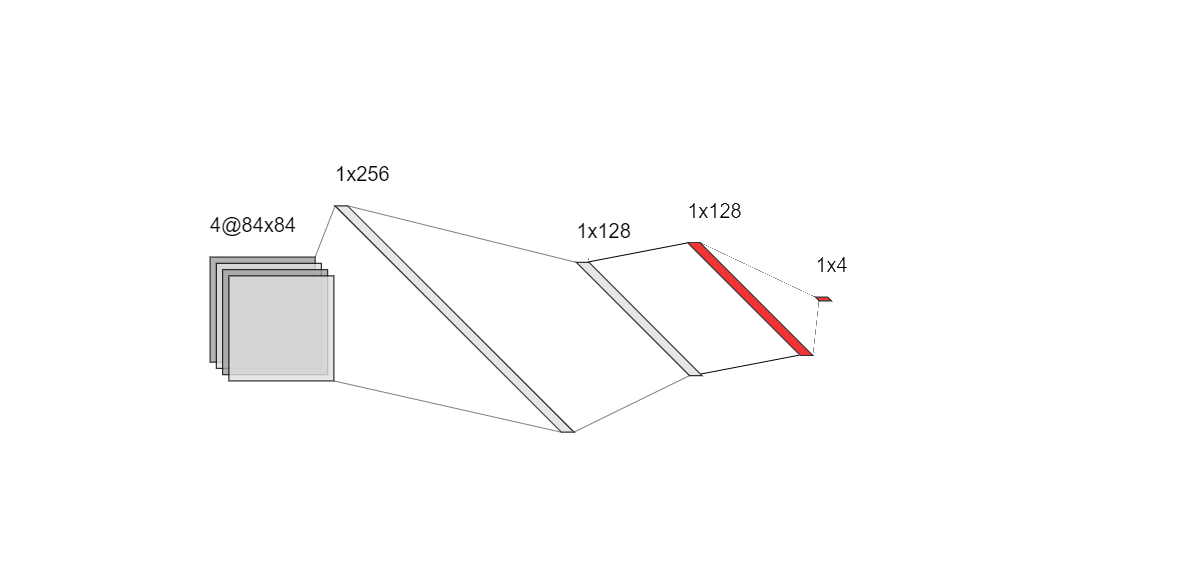
### Red is an ANN grey is the SNN

In [ ]:
import torch #for the last NN layer
import pyNN.spiNNaker as p
from functools import partial
from collections import deque

In [ ]:
class lastlayer(torch.nn.Module):

    def __init__(self):
        super(lastlayer, self).__init__()
        self.linear1 = torch.nn.Linear(64, ACTIONS)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.softmax(x)
        return x

In [ ]:
def run_spinnaker_sim(input_label, output_label, connection_port):
    inputpopsize = 84*84
    # Set up the simulation itself
    p.setup(1.0)
    
    print("SPIKY",p.external_devices.SpikeInjector(database_notify_port_num=connection_port))
    
    ##### INPUT LAYER #####
    input_pop = p.Population(inputpopsize,p.external_devices.SpikeInjector(
            database_notify_port_num=connection_port),label = input_label)
    ##### Middle LAYER #####
    middle_pop = p.Population(128,p.IF_curr_exp())

    #####   STDP    #####
    timing_rule = p.SpikePairRule(tau_plus=0.1, tau_minus=0.1, A_plus=0.1, A_minus=0.1)
    weight_rule = p.AdditiveWeightDependence(w_max=10.0, w_min=0.01)
    stdp_model_excitatory = p.STDPMechanism(timing_dependence=timing_rule, weight_dependence=weight_rule, weight=10)
    
    #### OUTPUT LAYER ####
    output_pop = p.Population(64,p.IF_curr_exp(),label = output_label)
    
    ## Create projections 
    inmid = p.Projection(
        input_pop,middle_pop,
        p.AllToAllConnector(),
        synapse_type=stdp_model_excitatory)
    
    midout = p.Projection(
        middle_pop,output_pop,
        p.AllToAllConnector(),
        synapse_type=stdp_model_excitatory)

    # Make the population output spikes
    p.external_devices.activate_live_output_for(output_pop, database_notify_port_num=connection_port)

    # Run in sections of 20ms
    p.external_devices.run_forever(sync_time=20)
    
    ##########SAVE THE MODEL#################
    """import pickle
    inmidweights, inmiddelays = inmid.get(["weight", "delay"], format="array")
    midoutweights, midoutdelays = midout.get(["weight", "delay"], format="array")
    with open("DQSNN_weights.pkl","wb") as f:
        pickle.dump({"inmidw":inmidweights,"inmidd":inmiddelays,"midoutw":midoutweights, "midoutd":midoutdelays},f)"""
    ##########################################
    # End the simulation once complete (run_forever stops when requested elsewhere)
    inmid.save("all",file="inmid")
    midout.save("all",file="midout")
    p.end()
    #print("xxLABLES",input_pop.get_data("spikes").segments[0].spiketrains[0])

In [ ]:
net = lastlayer()
#net = net.float()
def ann_predict(inputs):
    return net(inputs.to(torch.float))
def ann_train(inputs,targets):
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    optimizer.zero_grad()
    # Make predictions for this batch
    outputs = net(inputs)
    # Compute the loss and its gradients
    #print("outputs",outputs,"targets",targets)
    loss = loss_fn(outputs, targets)
    loss.backward()
    # Adjust learning weights
    optimizer.step()

# AI GYM MACHINERY 

# SETUP THE FIRST STAGE FIRST EXPLORATION STAGE

In [ ]:
# Parameters
global D 
D = deque()                                # Register where the actions will be stored

observetime = 50000                     # Number of timesteps we will be acting on the game and observing results
epsilon = 0.7                              # Probability of doing a random move
gamma = 0.9                                # Discounted future reward. How much we care about steps further in time
mb_size = 50                               # Learning minibatch size

# FIRST STEP: Knowing what each action does (Observing)

In [ ]:
#env  = Atari("MountainCar-v0")

In [ ]:
def run_openai_gym_sim_observation(input_label, connection, output_label, spike_queue, new_spike_queue, plt, img, env):
        # Parameters
    global D                                # Register where the actions will be stored

    observetime = 10                    # Number of timesteps we will be acting on the game and observing results
    epsilon = 0.7                              # Probability of doing a random move
    gamma = 0.9                                # Discounted future reward. How much we care about steps further in time
    mb_size = 50                               # Learning minibatch size
    observation = env.reset()
    done = False
    for t in range(observetime):

        if np.random.rand() <= epsilon:
            action = np.random.randint(0, env.action_space.n, size=1)[0]
        else:
            print("Spike Queues",spike_queue)
            Q = ann_predict(selectOutput(spike_queue))         # Q-values predictions #Sheesh
            action = np.argmax(Q.detach().numpy())             # Move with highest Q-value is the chosen one
        observation_new, reward, done, info = env.step(action)     # See state of the game, reward... after performing the action
        state = env.state         # Update state
        if done:
            env.reset()           # Restart game if it's finished    # (Formatting issues) Making the observation the first element of a batch of inputs 
            state = env.state
            
        #print("ENVSTATE",env.state)    
        #connection.send_spikes(input_label,inputToSpikeRateArray(env.state))#SPIKES TO BE SENT)
        
        old_spike_train = spike_queue
        new_spike_train = new_spike_queue
        
        D.append((env.state,old_spike_train,new_spike_train,action, reward, done))         # 'Remember' action and consequence
        
        connection.send_spikes(input_label,inputToSpikeRateArray(env.state))#SPIKES TO BE SENT)
        # Continue spinnaker simulation for next run of loop
        p.external_devices.continue_simulation()
        
    # Stop the OpenAI Gym
    #env.env.close()
    print('Observing Finished')
    # Stop SpiNNaker
    p.external_devices.request_stop()

In [ ]:
spike_queue = list()
new_spike_queue = []
# A function to receive spikes and put them in a queue
def receive_spikes(label, time, neuron_ids):
    print("xxLABELS",label, time, neuron_ids)
    spike_queue.insert(0,neuron_ids)
    new_spike_queue = []
    new_spike_queue.append(neuron_ids)

# Keep track of the labels these need to match up in several places
input_label = "input"
output_label = "output"

# Create the connection.
# Note the use of local_port=None allows the automatic assignment of a port.
connection = p.external_devices.SpynnakerLiveSpikesConnection(
    local_port=None, send_labels=[input_label], receive_labels=[output_label])

# Make the OpenAI Gym simulation
env = Atari(game)
#env = wrappers.Monitor(env, "/tmp/Breakout-v0", force=True)

# Display Breakout-v0 = plt.figure(figsize=(5, 5))
img = None#plt.imshow(env.env.render(mode='rgb_array'))

# Register the OpenAI Gym function to be called when the simulation starts
# Note: we have to use a label here so we chose input_label
connection.add_start_resume_callback(
    input_label, partial(run_openai_gym_sim_observation, output_label=output_label, spike_queue=spike_queue, new_spike_queue=new_spike_queue, plt=plt, img=img, env=env))

# Register the receive spikes function
connection.add_receive_callback(output_label, receive_spikes)

# Run the simulation
run_spinnaker_sim(input_label, output_label, connection.local_port)


# Replay memory and the use of bellman's equation to predict the highest quality incoming action
# SECOND STEP: Learning from the observations (Experience replay)

In [ ]:
torch.autograd.set_detect_anomaly(False)

In [ ]:
# SECOND STEP: Learning from the observations (Experience replay)
for epoch in tqdm(range(200000)):
    minibatch = random.sample(D, 1)                              # Sample some moves

    inputs = []
    targets = [0 for _ in range(env.action_space.n)]
    for i in range(0, len(minibatch)):
        state = minibatch[i][0]
        oldstatespikes = minibatch[i][1]
        newstatespikes = minibatch[i][2]
        action = minibatch[i][3]
        reward = minibatch[i][4]
        done = minibatch[i][5]

    # Build Bellman equation for the Q function
        inputs = selectOutput(oldstatespikes)
        targets = ann_predict(selectOutput(oldstatespikes))
        Q_sa = ann_predict(selectOutput(newstatespikes))
        #print(action,oldstatespikes,Q_sa)
        #print(np.max(Q_sa.detach().numpy()))
        if done:
            targets[action] = reward
        else:
            targets[action] = reward + gamma * np.max(Q_sa.detach().numpy())
        #print(targets.detach().numpy())
    # Train network to output the Q function
        ann_train(inputs,torch.tensor(targets.detach().numpy()))
print('Learning Finished')

# CREATE A CLASS THAT ALLOWS INFERENCE TO BE PERFORMED

In [ ]:
def run_spinnaker_sim_test(input_label, output_label, connection_port):
    inputpopsize = 84*84*4
    # Set up the simulation itself
    p.setup(10.0)
    print("RUNNIN AND ALL")

    ##### INPUT LAYER #####
    input_pop = p.Population(1,p.external_devices.SpikeInjector(database_notify_port_num=connection_port),label = input_label)
    ##### Middle LAYER #####
    middle_pop = p.Population(128,p.IF_curr_exp())

    #####   STDP    #####
    timing_rule = p.SpikePairRule(tau_plus=0.1, tau_minus=0.1, A_plus=0.1, A_minus=0.1)
    weight_rule = p.AdditiveWeightDependence(w_max=10.0, w_min=0.01)
    stdp_model_excitatory = p.STDPMechanism(timing_dependence=timing_rule, weight_dependence=weight_rule, weight=5)
    
    #### OUTPUT LAYER ####
    output_pop = p.Population(64,p.IF_curr_exp(),label = output_label)
    
    ######################### LOADING THE WEIGHTS #########################
    import pickle
    pickle_in = open("DQSNN_weights.pkl","rb")
    proj_dict = pickle.load(pickle_in)
    #print(len(proj_dict["inmidw"]))
    #stsyns0 = p.StaticSynapse(weight=proj_dict["inmidw"], delay=proj_dict["inmidd"])
    #stsyns1 = p.StaticSynapse(weight=proj_dict["midoutw"], delay=proj_dict["midoutd"])
    #stsyns0 = [p.StaticSynapse(weight=w, delay=d) for weights,delays in zip(proj_dict["inmidw"],proj_dict["inmidd"]) for w,d in zip(weights,delays)]
    #stsyns1 = [p.StaticSynapse(weight=w, delay=d) for weights,delays in zip(proj_dict["midoutw"],proj_dict["midoutd"]) for w,d in zip(weights,delays)]
    print("RUNNIN AND ALL")
    ## Create projections 
    #inmid = p.Projection(input_pop,middle_pop,p.AllToAllConnector(),synapse_type=stsyns0)
    #midout = p.Projection(middle_pop,output_pop,p.AllToAllConnector(),synapse_type=stsyns1)
    inmid = p.Projection(input_pop,middle_pop, p.FromFileConnector("inmid"))
    midout = p.Projection(middle_pop,output_pop, p.FromFileConnector("midout"))
    #inmid = p.Projection(input_pop,middle_pop, p.FromListConnector(proj_dict["inmidw"]))
    #midout = p.Projection(middle_pop,output_pop, p.FromListConnector(proj_dict["midoutw"]))
    print("RUNNIN AND ALL")
    
    # Make the population output spikes
    p.external_devices.activate_live_output_for(output_pop, database_notify_port_num=connection_port)
    # Run in sections of 20ms
    p.external_devices.run_forever(sync_time=40)
    # End the simulation once complete (run_forever stops when requested elsewhere)
    p.end()

# Play the game

In [ ]:
def run_openai_gym_sim_play(input_label, connection, output_label, spike_queue, new_spike_queue, plt, img, env):
    frames = []
    observation = env.reset()
    state = env.state
    done = False
    tot_reward = 0.0
    while not done:
        env.render()
        print(ann_predict(selectOutput(spike_queue)),selectOutput(spike_queue),spike_queue)
        Q = ann_predict(selectOutput(spike_queue))        
        action = np.argmax(Q.detach().numpy())
        print("ACTION",action)
        observation, reward, done, new_frame = env.step(action)
        frames.append(new_frame)
        tot_reward += reward

    # TODO: Use the output from the environment to send spikes to SpiNNaker
    connection.send_spikes(input_label,inputToSpikeRateArray(env.state))#SPIKES TO BE SENT)

    # Continue spinnaker simulation for next run of loop
    p.external_devices.continue_simulation()

    # Stop the OpenAI Gym
    #env.env.close()
    generate_gif(frames)
    print('Game ended! Total reward: {}'.format(tot_reward))
    # Stop SpiNNaker
    p.external_devices.request_stop()

In [ ]:
spike_queue = list()
new_spike_queue = []
# A function to receive spikes and put them in a queue
def receive_spikes(label, time, neuron_ids):
    spike_queue.insert(0,neuron_ids)
    new_spike_queue = []
    new_spike_queue.append(neuron_ids)

# Keep track of the labels these need to match up in several places
input_label = "input"
output_label = "output"

# Create the connection.
# Note the use of local_port=None allows the automatic assignment of a port.
connection = p.external_devices.SpynnakerLiveSpikesConnection(
    local_port=None, send_labels=[input_label], receive_labels=[output_label])

# Make the OpenAI Gym simulation
env = Atari(game)
#env = wrappers.Monitor(env, "/tmp/Breakout-v0", force=True)

# Display Breakout-v0 = plt.figure(figsize=(5, 5))
img = None#plt.imshow(env.env.render(mode='rgb_array'))

# Register the OpenAI Gym function to be called when the simulation starts
# Note: we have to use a label here so we chose input_label
connection.add_start_resume_callback(
    input_label, partial(run_openai_gym_sim_play, output_label=output_label, spike_queue=spike_queue, new_spike_queue=new_spike_queue, plt=plt, img=img, env=env))

# Register the receive spikes function
connection.add_receive_callback(output_label, receive_spikes)

# Run the simulation
#run_spinnaker_sim_test(input_label, output_label, connection.local_port)
run_spinnaker_sim_test(input_label, output_label, connection.local_port)